In [6]:
import numpy as np
import os
import pandas as pd
import h5py
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [8]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [9]:
# set random seed for reproducibility
set_random_seed(seed=42)

2025-12-12 01:48:51.949652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-12-12 01:48:51.949675: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


Seed set to 42


# Distribution of coverages (again, but different)

Take atac_hgp_df. For every atac peak in there, I want to know if I take the interval [X-summit; X+summit] for different values of X, what percetnage of the associated hgp does that interval cover.

In [2]:
!head /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_extended_gapped_peak_histone_intersect_2114bp_atac_for_train.bed

chrom	start	end	hist_chrom	hist_start	hist_end
chr1	39778	41892	.	-1	-1
chr1	40034	42148	.	-1	-1
chr1	40545	42659	.	-1	-1
chr1	41223	43337	.	-1	-1
chr1	45439	47553	.	-1	-1
chr1	45861	47975	.	-1	-1
chr1	66671	68785	.	-1	-1
chr1	67140	69254	.	-1	-1
chr1	68021	70135	.	-1	-1


In [10]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_extended_gapped_peak_histone_intersect_2114bp_atac_for_train.bed"
atac_hgp_df = pd.read_csv(p, sep='\t', header=0)
atac_hgp_df

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,39778,41892,.,-1,-1
1,chr1,40034,42148,.,-1,-1
2,chr1,40545,42659,.,-1,-1
3,chr1,41223,43337,.,-1,-1
4,chr1,45439,47553,.,-1,-1
...,...,...,...,...,...,...
269713,chrY,11097555,11099669,.,-1,-1
269714,chrY,11102145,11104259,.,-1,-1
269715,chrY,12393985,12396099,.,-1,-1
269716,chrY,12394138,12396252,.,-1,-1


In [13]:
# i want to know if this is always even or not
((atac_hgp_df["start"] + atac_hgp_df["end"]) % 2).sum()

0

In [27]:
atac_hgp_df_valid = atac_hgp_df[atac_hgp_df["hist_chrom"] != "."].copy()
(atac_hgp_df_valid["chrom"] == atac_hgp_df_valid["hist_chrom"]).all()

True

In [ ]:
# I have a bed file like this where each line is a summit-centered 2114bp atac peak, and the last 3 columns are the coordinates of a histone peak that is associated with this atac peak. I want to compute, for different values of X, what percentage of the histone peak is covered by the interval [summit - X; summit + X], where summit is the summit of the atac peak.

In [ ]:
def compute_histone_coverage(df, x_values):
    """
    Computes the percentage of histone peak covered by [summit-X, summit+X].
    
    Args:
        file_path: Path to the BED file.
        x_values: A list of integers representing the radius X.
    """
    
    # 2. Extract Coordinates
    # ATAC coordinates (First 3 columns)
    atac_start = df.iloc[:, 1]
    atac_end = df.iloc[:, 2]
    
    # Histone coordinates (Last 3 columns)
    # Using negative indexing to be safe regardless of how many metadata columns exist
    hist_start = df.iloc[:, -2] 
    hist_end = df.iloc[:, -1]
    hist_len = hist_end - hist_start

    # 3. Calculate Summit (Midpoint of ATAC peak)
    # Since peaks are summit-centered, integer division of (start + end) / 2 works
    summits = (atac_start + atac_end) // 2

    results = {}

    # 4. Iterate over X values (Vectorized for speed)
    for x in x_values:
        # Define the window around the summit
        window_start = summits - x
        window_end = summits + x
        
        # Calculate overlap coordinates
        # overlap_start is max(hist_start, window_start)
        overlap_start = np.maximum(hist_start, window_start)
        
        # overlap_end is min(hist_end, window_end)
        overlap_end = np.minimum(hist_end, window_end)
        
        # Calculate overlap length
        # Must be at least 0 (if no overlap, subtraction gives negative)
        # overlap_len = np.maximum(0, overlap_end - overlap_start)
        # valeh: instead of taking the max, just report the actual value
        # we dont expect any negatives by construction of atac_hgp_df
        # so we want to know if there are negatives
        overlap_len = overlap_end - overlap_start

        # Calculate fraction covered
        fraction_covered = overlap_len / hist_len
        pct_covered = fraction_covered * 100

        # Store the coverage
        results[x] = pct_covered.to_numpy()
        # results[x] = pct_covered.mean()

    return results

width_range = [200, 500, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
x_range = [w // 2 for w in width_range]
coverage_stats = compute_histone_coverage(atac_hgp_df_valid, x_range)

In [40]:
# print(f"{'X bp (summit-centered)':<15} {'Avg Histone Coverage (%)':<25}")
# print("-" * 40)
for x, cov in coverage_stats.items():
    print(f"an average {x*2}bp summit-centered  atac peak covers {np.mean(cov):.2f}% of its hgp")

print("-" * 40)

for x, cov in coverage_stats.items():
    print(f"95% of {x*2}bp summit-centered atac peaks cover >= {np.percentile(cov, 5):.2f}% of their hgp")

print("-" * 40)

for x, cov in coverage_stats.items():
    print(f"75% of {x*2}bp summit-centered atac peaks cover >= {np.percentile(cov, 25):.2f}% of their hgp")

an average 200bp summit-centered  atac peak covers 8.83% of its hgp
an average 500bp summit-centered  atac peak covers 21.10% of its hgp
an average 800bp summit-centered  atac peak covers 31.93% of its hgp
an average 1000bp summit-centered  atac peak covers 38.27% of its hgp
an average 2000bp summit-centered  atac peak covers 61.35% of its hgp
an average 3000bp summit-centered  atac peak covers 74.13% of its hgp
an average 4000bp summit-centered  atac peak covers 81.39% of its hgp
an average 5000bp summit-centered  atac peak covers 85.90% of its hgp
an average 6000bp summit-centered  atac peak covers 88.96% of its hgp
an average 7000bp summit-centered  atac peak covers 91.12% of its hgp
an average 8000bp summit-centered  atac peak covers 92.73% of its hgp
an average 9000bp summit-centered  atac peak covers 93.97% of its hgp
an average 10000bp summit-centered  atac peak covers 94.95% of its hgp
----------------------------------------
95% of 200bp summit-centered atac peaks cover >= 1.5

In [45]:
pd.Series(coverage_stats[3000]).describe()

count    63771.000000
mean        88.959951
std         20.755344
min          7.467718
25%         87.855165
50%        100.000000
75%        100.000000
max        100.000000
dtype: float64

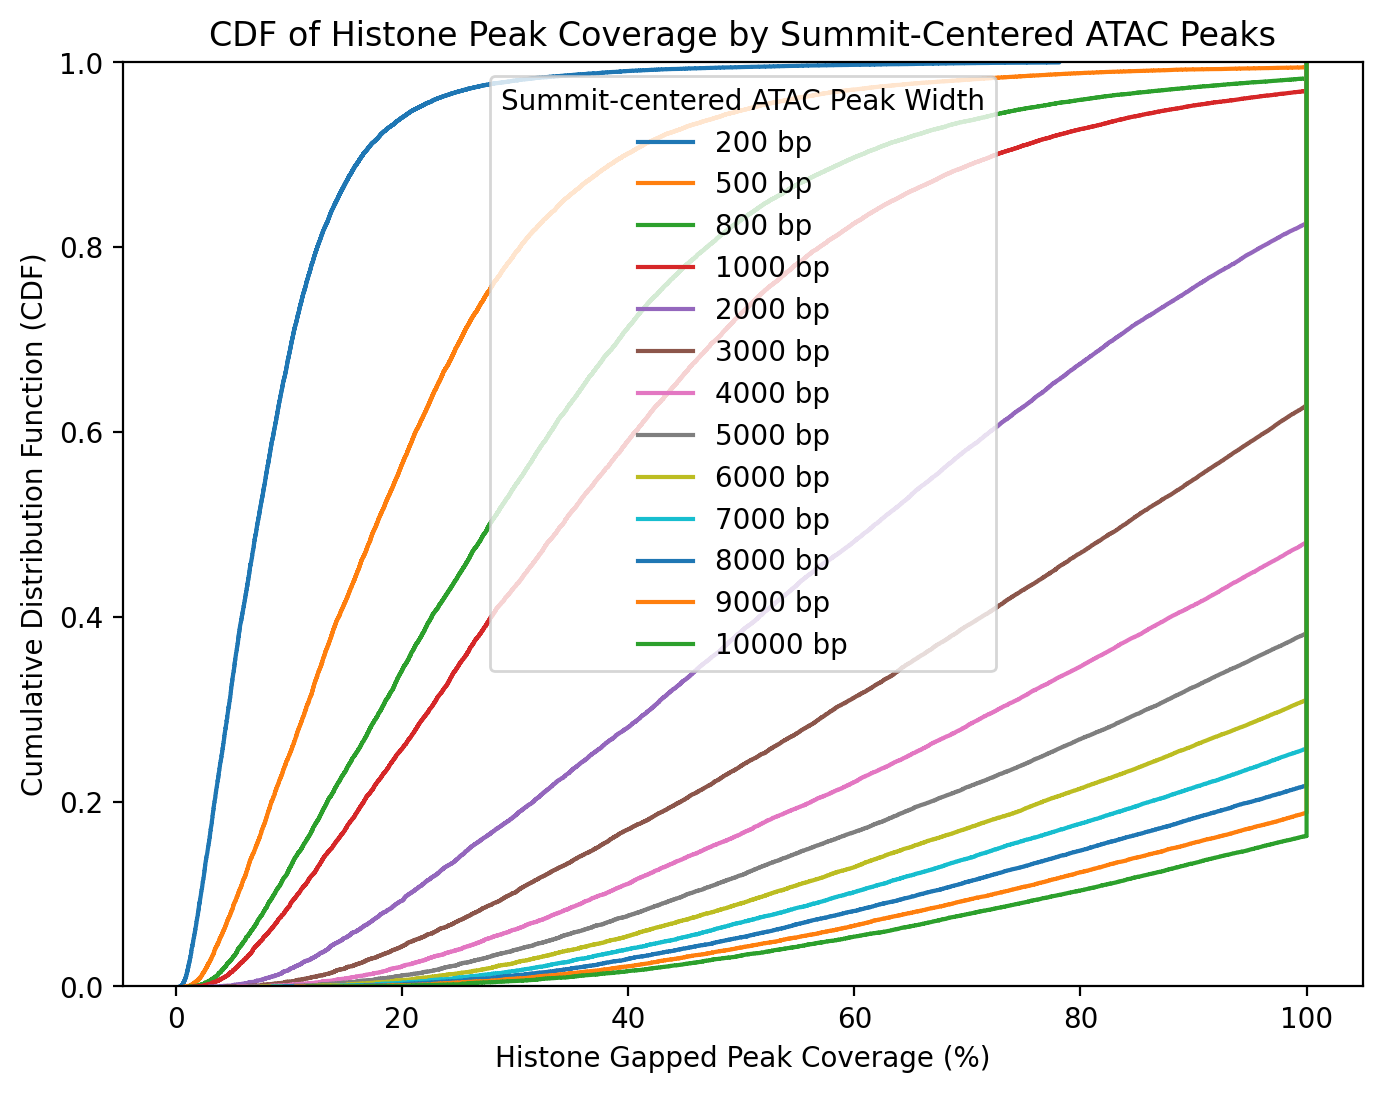

In [47]:
# plot cdf
plt.figure(figsize=(8, 6))
for x, cov in coverage_stats.items():
    sns.ecdfplot(cov, label=f"{x*2} bp")
plt.xlabel("Histone Gapped Peak Coverage (%)")
plt.ylabel("Cumulative Distribution Function (CDF)")
plt.title("CDF of Histone Peak Coverage by Summit-Centered ATAC Peaks")
plt.legend(title="Summit-centered ATAC Peak Width")
plt.show()